![image.png](https://i.imgur.com/a3uAqnb.png)

# Introduction to Convolutional Neural Networks (CNNs)
A step-by-step guide using PyTorch and FashionMNIST.

In [66]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

## 1. Loading the FashionMNIST Dataset
We use FashionMNIST, a beginner-friendly dataset of clothing images.

In [67]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=1000, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)
class_names = train_dataset.classes

## Visualizing Sample Images

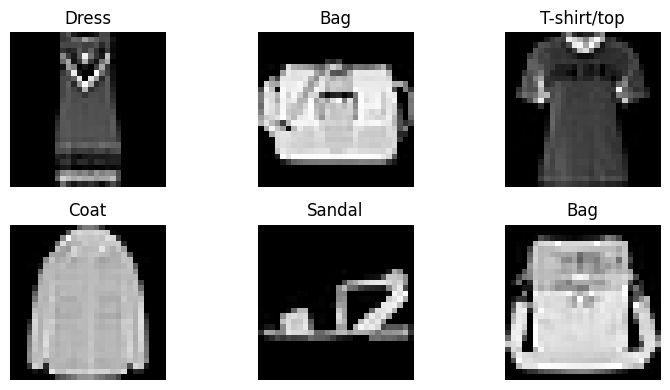

In [68]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
fig = plt.figure(figsize=(8, 4))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(example_data[i][0], cmap='gray')
    plt.title(class_names[example_targets[i]])
    plt.axis('off')
plt.tight_layout()
plt.show()

## 2. Defining the CNN Model

In [75]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Always check the number of channels (color mode) of your data
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 3 * 3, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # 28 x 28 -> 14 x 14
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x))) # 14 x 14 -> 7 x 7
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv3(x))) # 7 x 7 -> 3 x 3
        x = self.dropout(x)
        x = (F.relu(self.conv4(x))) # 3 x 3 -> 1 x 1
        x = self.dropout(x)
        x = x.view(-1, 128 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN()
model.to(device)

SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1152, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
)

## 3. Loss Function and Optimizer

In [76]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

## 4. Training the Model

In [77]:
train_losses = []
val_losses = []
epochs = 10

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation (test set loss)
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Validating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")


Validating: 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]


Epoch 1/10, Train Loss: 1.0298, Val Loss: 0.5971


Validating: 100%|██████████| 10/10 [00:01<00:00,  5.11it/s]


Epoch 2/10, Train Loss: 0.5482, Val Loss: 0.4803


Validating: 100%|██████████| 10/10 [00:01<00:00,  5.42it/s]


Epoch 3/10, Train Loss: 0.4590, Val Loss: 0.4046


Validating: 100%|██████████| 10/10 [00:01<00:00,  5.06it/s]


Epoch 4/10, Train Loss: 0.4032, Val Loss: 0.3602


Validating: 100%|██████████| 10/10 [00:01<00:00,  5.03it/s]


Epoch 5/10, Train Loss: 0.3750, Val Loss: 0.3451


Validating: 100%|██████████| 10/10 [00:02<00:00,  4.99it/s]


Epoch 6/10, Train Loss: 0.3498, Val Loss: 0.3202


Validating: 100%|██████████| 10/10 [00:01<00:00,  5.39it/s]


Epoch 7/10, Train Loss: 0.3287, Val Loss: 0.2959


Validating: 100%|██████████| 10/10 [00:01<00:00,  5.30it/s]


Epoch 8/10, Train Loss: 0.3122, Val Loss: 0.2892


Validating: 100%|██████████| 10/10 [00:02<00:00,  4.68it/s]


Epoch 9/10, Train Loss: 0.3015, Val Loss: 0.2797


Validating: 100%|██████████| 10/10 [00:01<00:00,  5.28it/s]

Epoch 10/10, Train Loss: 0.2885, Val Loss: 0.2642


## Training Loss Curve

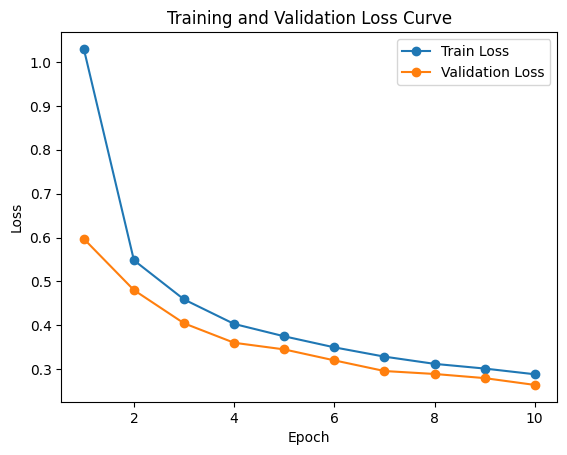

In [78]:
plt.plot(range(1, epochs + 1), train_losses, marker='o', label='Train Loss')
plt.plot(range(1, epochs + 1), val_losses, marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.show()


## 5. Testing the Model

In [79]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
avg_accuracy = 100 * correct / total
print(f'Accuracy on the test set: {avg_accuracy:.2f}%')

Accuracy on the test set: 90.19%


## Visualizing Predictions vs. Ground Truth

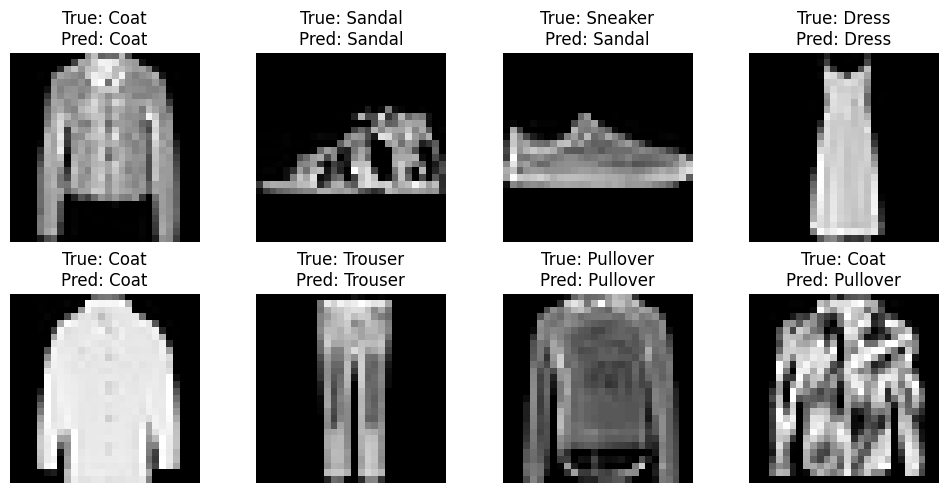

In [80]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)
outputs = model(images)
images = images.cpu()
_, preds = torch.max(outputs, 1)
fig = plt.figure(figsize=(10, 5))
for idx in range(8):
    plt.subplot(2, 4, idx+1)
    plt.imshow(images[idx+10][0], cmap='gray')
    plt.title(f'True: {class_names[labels[idx+10]]}\nPred: {class_names[preds[idx+10]]}')
    plt.axis('off')
plt.tight_layout()
plt.show()